In [1]:
import os

dataset_path = "/kaggle/input/cardetection"

# Walk through dataset directory and list number of filed
for dirpath, dirnames, filenames in os.walk(dataset_path):
    print(f'There are  {len(dirnames)} directories and {len(filenames)} files in {dirpath}')

There are  3 directories and 3 files in /kaggle/input/cardetection
There are  2 directories and 0 files in /kaggle/input/cardetection/valid
There are  0 directories and 801 files in /kaggle/input/cardetection/valid/labels
There are  0 directories and 801 files in /kaggle/input/cardetection/valid/images
There are  2 directories and 0 files in /kaggle/input/cardetection/test
There are  0 directories and 638 files in /kaggle/input/cardetection/test/labels
There are  0 directories and 638 files in /kaggle/input/cardetection/test/images
There are  2 directories and 0 files in /kaggle/input/cardetection/train
There are  0 directories and 3530 files in /kaggle/input/cardetection/train/labels
There are  0 directories and 3530 files in /kaggle/input/cardetection/train/images


In [2]:
!pip install --upgrade -q wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api  = user_secrets.get_secret("w&b")

In [3]:
import wandb
import yaml
from wandb.keras import WandbCallback
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
import shutil

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)

tf.random.set_seed(42)

wandb.login(key=wandb_api)

2.13.0


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.figure()
    plt.plot(epochs, loss, label = 'training loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.legend()

    # Plot accuracy
    plt.figure() # Everytime you want a new plot
    plt.plot(epochs, accuracy, label = 'accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.legend()

In [5]:
# Get the classnames programmatically 

with open(dataset_path+"/data.yaml", "r") as stream:
    try:
        data_loaded = yaml.safe_load(stream)
#         print(yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)
        
data_loaded

{'train': '../train/images',
 'val': '../valid/images',
 'test': '../test/images',
 'nc': 15,
 'names': ['Green Light',
  'Red Light',
  'Speed Limit 10',
  'Speed Limit 100',
  'Speed Limit 110',
  'Speed Limit 120',
  'Speed Limit 20',
  'Speed Limit 30',
  'Speed Limit 40',
  'Speed Limit 50',
  'Speed Limit 60',
  'Speed Limit 70',
  'Speed Limit 80',
  'Speed Limit 90',
  'Stop'],
 'roboflow': {'workspace': 'selfdriving-car-qtywx',
  'project': 'self-driving-cars-lfjou',
  'version': 6,
  'license': 'CC BY 4.0',
  'url': 'https://universe.roboflow.com/selfdriving-car-qtywx/self-driving-cars-lfjou/dataset/6'}}

In [6]:
keys = data_loaded['names']
class_names = {i : keys[i] for i in range(len(keys))}
class_names

{0: 'Green Light',
 1: 'Red Light',
 2: 'Speed Limit 10',
 3: 'Speed Limit 100',
 4: 'Speed Limit 110',
 5: 'Speed Limit 120',
 6: 'Speed Limit 20',
 7: 'Speed Limit 30',
 8: 'Speed Limit 40',
 9: 'Speed Limit 50',
 10: 'Speed Limit 60',
 11: 'Speed Limit 70',
 12: 'Speed Limit 80',
 13: 'Speed Limit 90',
 14: 'Stop'}

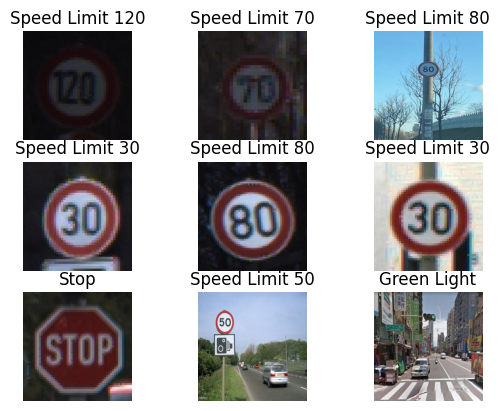

In [7]:
train_img = dataset_path+'/train/images'
train_labels = dataset_path+'/train/labels'

def plot_images(images_path, labels_path):
    
    num_rows=3
    num_cols=3
    
    # Get a list of image files
    image_files = os.listdir(images_path)
#     label_files = os.listdir(labels_path)
    
    # Randomly select num_rows * num_cols images
    selected_images = random.sample(image_files, num_rows * num_cols)

    # Plot images in a grid
    fig, axes = plt.subplots(num_rows, num_cols)

    for i, image_file in enumerate(selected_images):
        # Load and plot the image
        image_path = os.path.join(images_path, image_file)
        img = mpimg.imread(image_path)
        axes[i // num_cols, i % num_cols].imshow(img)
        axes[i // num_cols, i % num_cols].axis('off')

        # Load and print the corresponding label
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_path, label_file)
        with open(label_path, 'r') as label_file:
            label_info = label_file.read().split()[0]  # Extract a substring
        
        axes[i // num_cols, i % num_cols].set_title(class_names[int(label_info)])

    plt.show()
    
plot_images(train_img, train_labels)

> Through random image sampling it becomes clear that while the speed limit images are trainable, the red light and green light classes are of poor quality. Therefore the multiclass classification will for now ignore these two classes.

Separating the Data into workable directories

In [8]:
artifact = wandb.Artifact(name="raw_data", type="dataset")
# Create a W&B Run. Replace 'job-type'.
run = wandb.init(project="traffic_signs_detection", job_type="dataset")
# Recursively add a directory
artifact.add_dir(local_path="/kaggle/input/cardetection", name="raw_data")
run.log_artifact(artifact)

wandb: Currently logged in as: ramsik. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231211_080245-88bbpg51
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run polar-breeze-7
wandb: ⭐️ View project at https://wandb.ai/ramsik/traffic_signs_detection
wandb: 🚀 View run at https://wandb.ai/ramsik/traffic_signs_detection/runs/88bbpg51
wandb: Adding directory to artifact (/kaggle/input/cardetection)... Done. 13.0s


<Artifact raw_data>

In [9]:
# making dataframe 

def build_df(target_dir, class_names = class_names):
    target = os.path.basename(target_dir)
    labels_dir = target_dir + '/labels'
    image_dir = target_dir + '/images'
    label_files = os.listdir(labels_dir)
    dest_base = '/kaggle/working/'
    dest_target = os.path.join(dest_base, target)
    df = []
    failed = []
    
    for file_name in label_files:   
        img_name = file_name.replace(".txt", ".jpg")    
            
        label_file_path = os.path.join(labels_dir, file_name)
#         print(label_file_path)
        orig_img_path = os.path.join(image_dir, img_name)

        with open(label_file_path, 'r') as label_file:
            lines = label_file.readlines()
        if len(lines) > 0:  # removing bad data
            img_class = int(lines[0].split()[0])
        else:
            failed.append([target, orig_img_path, label_file_path])
            continue

        dest_folder = class_names[img_class]
        dest_path = os.path.join(dest_target, dest_folder, img_name)

        df.append([target, img_class, dest_folder, orig_img_path, dest_path])
#         break
    
    dataframe = pd.DataFrame(df, 
                             columns = ['target', 'class_num','class', 'orig_img_path', 'dest_path'])
    failed_df = pd.DataFrame(failed, 
                                    columns = ['target', 'orig_img_path', 'label_file_path'])
    
    return dataframe, failed_df

In [10]:
train_df, train_failed = build_df('/kaggle/input/cardetection/train')
test_df, test_failed = build_df('/kaggle/input/cardetection/test')
val_df, val_failed = build_df('/kaggle/input/cardetection/valid')

print('Total entries in train: ', len(train_df),'\n',
      'Failed entries in train: ', len(train_failed), '\n',
      'Total entries in test: ', len(test_df), '\n', 
      'Failed entries in test: ', len(test_failed), '\n', 
      'Total entries in val: ', len(val_df), '\n', 
      'Failed entries in val: ', len(val_failed)
     )

Total entries in train:  3527 
 Failed entries in train:  3 
 Total entries in test:  637 
 Failed entries in test:  1 
 Total entries in val:  801 
 Failed entries in val:  0


In [11]:
combined_df = pd.concat([train_df, test_df, val_df])
combined_failed = pd.concat([train_failed, test_failed, val_failed])
combined_df.groupby(['target','class'])['class'].count()

target  class          
test    Green Light         69
        Red Light           56
        Speed Limit 10       2
        Speed Limit 100     41
        Speed Limit 110     20
        Speed Limit 120     35
        Speed Limit 20      44
        Speed Limit 30      56
        Speed Limit 40      47
        Speed Limit 50      45
        Speed Limit 60      43
        Speed Limit 70      47
        Speed Limit 80      55
        Speed Limit 90      30
        Stop                47
train   Green Light        317
        Red Light          326
        Speed Limit 10      11
        Speed Limit 100    225
        Speed Limit 110     86
        Speed Limit 120    222
        Speed Limit 20     264
        Speed Limit 30     312
        Speed Limit 40     214
        Speed Limit 50     249
        Speed Limit 60     286
        Speed Limit 70     298
        Speed Limit 80     297
        Speed Limit 90     142
        Stop               278
valid   Green Light         71
        Red Lig

In [12]:
combined_failed = combined_failed.reset_index().drop('index', axis = 1)
combined_failed.label_file_path[0]

'/kaggle/input/cardetection/train/labels/FisheyeCamera_1_00926_png.rf.511cfac04ff48a1fe99b560b4a4fb9e2.txt'

In [13]:
combined_df = combined_df.reset_index().drop('index', axis = 1)
combined_df.to_csv('/kaggle/working/speedlimit_signs.csv', index=False)

From the above we notice that the classes 'Speed Limit 10' and 'Speed Limit 110' are underrepresented. No images for class 'Speed Limit 10' exist in the val set, with 11 in train set and only 2 in test. Therefore we will be skipping these two classes as well.

Multiclass Classification will therefore be on the following classes
* Speed Limit 100  
* Speed Limit 120  
* Speed Limit 20  
* Speed Limit 30  
* Speed Limit 40  
* Speed Limit 50  
* Speed Limit 60  
* Speed Limit 70   
* Speed Limit 80  
* Speed Limit 90
* Stop               

In [14]:
run = wandb.init(project="traffic_signs_detection", job_type="dataset")
saved_artifact = run.use_artifact("raw_data:v0")
draft_artifact = saved_artifact.new_draft()
draft_artifact.add_file(local_path="/kaggle/working/speedlimit_signs.csv", name="speedlimit_signs")
run.log_artifact(draft_artifact)

<Artifact raw_data>

In [15]:
selected_classes = ['Speed Limit 100',
                    'Speed Limit 120',
                    'Speed Limit 20',
                    'Speed Limit 30',
                    'Speed Limit 40',
                    'Speed Limit 50',
                    'Speed Limit 60',
                    'Speed Limit 70',
                    'Speed Limit 80',
                    'Speed Limit 90'
                   ]

target_dirs = ['/kaggle/working/train/',
              '/kaggle/working/valid/',
              '/kaggle/working/test/']

def make_dirs(target_dir, class_names=selected_classes):
    for class_n in class_names:
        target_path = os.path.join(target_dir, class_n)
        print("Creating Folder", target_path)
        os.makedirs(target_path)

for target_dir in target_dirs:
    if os.path.exists(target_dir)==False:
        print("Creating Target Directory", target_dir)
        os.makedirs(target_dir)
    make_dirs(target_dir)

Creating Target Directory /kaggle/working/train/
Creating Folder /kaggle/working/train/Speed Limit 100
Creating Folder /kaggle/working/train/Speed Limit 120
Creating Folder /kaggle/working/train/Speed Limit 20
Creating Folder /kaggle/working/train/Speed Limit 30
Creating Folder /kaggle/working/train/Speed Limit 40
Creating Folder /kaggle/working/train/Speed Limit 50
Creating Folder /kaggle/working/train/Speed Limit 60
Creating Folder /kaggle/working/train/Speed Limit 70
Creating Folder /kaggle/working/train/Speed Limit 80
Creating Folder /kaggle/working/train/Speed Limit 90
Creating Target Directory /kaggle/working/valid/
Creating Folder /kaggle/working/valid/Speed Limit 100
Creating Folder /kaggle/working/valid/Speed Limit 120
Creating Folder /kaggle/working/valid/Speed Limit 20
Creating Folder /kaggle/working/valid/Speed Limit 30
Creating Folder /kaggle/working/valid/Speed Limit 40
Creating Folder /kaggle/working/valid/Speed Limit 50
Creating Folder /kaggle/working/valid/Speed Limit 

In [16]:
combined_df = combined_df.reset_index().drop('index', axis = 1)
combined_df.head()

,target,class_num,class,orig_img_path,dest_path
0,train,6,Speed Limit 20,/kaggle/input/cardetection/train/images/00000_...,/kaggle/working/train/Speed Limit 20/00000_000...
1,train,0,Green Light,/kaggle/input/cardetection/train/images/132fb1...,/kaggle/working/train/Green Light/132fb160-d28...
2,train,12,Speed Limit 80,/kaggle/input/cardetection/train/images/road49...,/kaggle/working/train/Speed Limit 80/road498_p...
3,train,11,Speed Limit 70,/kaggle/input/cardetection/train/images/00004_...,/kaggle/working/train/Speed Limit 70/00004_000...
4,train,6,Speed Limit 20,/kaggle/input/cardetection/train/images/00000_...,/kaggle/working/train/Speed Limit 20/00000_000...


In [17]:
# Moving images into train test folders
failed_list = []
for i, row in combined_df.iterrows(): 
    
    class_ = row['class']
    
#     print(src, '\n',dest)
#     break
    if class_ in selected_classes: 
        src = row.orig_img_path	
        dest = row.dest_path
        target = row.target
        
        try:
            shutil.copyfile(src, dest)

        # If file missing at src
        except FileNotFoundError:
            print('FileNotFound')
            failed_list.append(["FileMissing", src, dest, target, class_])
            continue

        # If source and destination are same
        except shutil.SameFileError:
            print("Source and destination represents the same file.")
            failed_list.append(["SameFile", src, dest, target, class_])

        # If destination is a directory.
        except IsADirectoryError:
            print("Destination is a directory.")
            failed_list.append(["Directory", src, dest, target, class_])

        # If there is any permission issue
        except PermissionError:
            print("Permission denied.")
            failed_list.append(["Denied", src, dest, target, class_])
        
print(f'Total files failed to move: {len(failed_list)}')

Total files failed to move: 0


In [18]:
artifact = wandb.Artifact(name="multiclass_classification_data", type="dataset")
# Create a W&B Run.
run = wandb.init(project="traffic_signs_detection", job_type="dataset")
# Recursively add a directory
artifact.add_dir(local_path="/kaggle/working", name="multiclass_classification_data")
run.log_artifact(artifact)

wandb: Adding directory to artifact (/kaggle/working)... 

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/wandb/debug-internal.log'

In [ ]:
# Preprocess data (normalize)
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = '/kaggle/working/train/'
test_dir = '/kaggle/working/test'
val_dir = '/kaggle/working/valid/'

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               batch_size = 32,
                                               target_size = (224, 224),
                                               class_mode = 'categorical',
                                               seed = 42)
valid_data = valid_datagen.flow_from_directory(directory = val_dir,
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = 'categorical',
                                               seed = 42)
test_data = test_datagen.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = 'categorical',
                                               seed = 42,
                                                shuffle = False)

# Build a CNN model (same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.Sequential([
                               Conv2D(10, 3, input_shape=(224,224,3)),
                               Activation(activation='relu'),
                               Conv2D(10, 3, activation= 'relu'),
                               MaxPool2D(),
                               Conv2D(10, 3, activation = 'relu'),
                               Conv2D(10, 3, activation = 'relu'),
                               MaxPool2D(),
                               Flatten(),
                               Dense(10), # changed to have 10 output neurons and use the softmax activation function
                               Activation(activation = 'softmax')
])

# Compile the model
model_1.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = Adam(),
                metrics = ['accuracy'])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = int(0.25 * len(valid_data))
                       )

In [ ]:
# Get a model summary
model_1.summary()

In [ ]:
model_1.evaluate(test_data)

In [ ]:
plot_loss_curves(history_1)

In [ ]:
# Save model
model_1.save('baseline_tinyVGG')

In [ ]:
# Save model as an Artifact
artifact = wandb.Artifact(name='baseline_tinyVGG', type='model')
artifact.add_dir('/kaggle/working/baseline_tinyVGG')
run.log_artifact(artifact)